This is a notebook aiming to explore KNN graphs of image embeddings.

# 0. Import Dependencies

In [1]:
import pynndescent # https://pynndescent.readthedocs.io/en/latest/how_to_use_pynndescent.html#Nearest-neighbors-of-the-training-set
from PIL import Image # Pillow
import os # for getting filenames

from concurrent.futures import ThreadPoolExecutor # for parallel processing
from tqdm import tqdm # for progress bars

import numpy as np

### Embedding options ###
## VGG16 ##
from torch.utils.data import DataLoader
from dataset import ImageDataset
from torchvision import transforms
import torch
from torchvision import models
## Surf ##
# import cv2 as cv

## Clip ## # Meta clip
from imgbeddings import imgbeddings # ensure using huggingface-hub v0.25.0 or earlier to prevent import issue

## Kmeans clustering ##
from sklearn.cluster import KMeans

## Plotting ##
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps

# Force directed diagram # 
import networkx as nx
from scipy.stats import gaussian_kde
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import json

# adding images to html
import base64
from io import BytesIO
# for incorporating plotly
import requests


import random

random.seed(42) 
np.random.seed(42)
torch.manual_seed(42)

# for flexible image loading
from PIL import UnidentifiedImageError
import zipfile
import os 

# 1. Load images 

In [32]:
def get_images_and_filenames(image_container, excluded_nested_folders=[]):
    """Image container can be a zip or folder, can have nested folders within

    excluded nested folders is the name of the folder when inside the image_container, 
    or the "path" to the folder inside the image_container excluding ./ at the start 
    
    returns pillow_images (list), image_filenames (np array)"""
    image_filenames = []
    pillow_images = []

    try:
        imgzip = zipfile.ZipFile(image_container)
        inflist = imgzip.infolist()

        # the easiest way to do it is to write an image to memory
        for f in tqdm(inflist):
            ifile = imgzip.open(f)
            try:
                # check its not an excluded folder
                if any(["/".join(ifile.name.split('/')[1:]).startswith(excluded_nested_folder+"/") 
                        for excluded_nested_folder in excluded_nested_folders]):
                    continue

                # print(ifile)
                img = Image.open(ifile)
                pillow_images.append(img)
                image_filenames.append("/".join(ifile.name.split('/')[1:]))
            
                # print("/".join(ifile.name.split('/')[1:])) # these will become the image filenames
                # print(img)
                # display(img)
            except UnidentifiedImageError as e: # for directories etc.
                # print(e) 
                pass

    except IsADirectoryError:
        for root, dirs, files in tqdm(os.walk(image_container)):
            for file in files:
                try:
                    # print(ifile)
                    filepath = os.path.join(root, file)

                    if any(["/".join(filepath.split('/')[2:]).startswith(excluded_nested_folder+"/") # add / to ensure its the "whole" folder name and not just matching the start
                        for excluded_nested_folder in excluded_nested_folders]):
                        break
                    
                    img = Image.open(filepath)
                    pillow_images.append(img)
                    image_filenames.append("/".join(filepath.split('/')[2:]))
                
                    # print("/".join(ifile.name.split('/')[1:])) # these will become the image filenames
                    # print(img)
                    # display(img)
                except UnidentifiedImageError as e: # for directories etc.
                    # print(e) 
                    pass      


    return pillow_images, np.array(image_filenames)

In [53]:
IMAGE_CONTAINER = "./images.zip"

pillow_images, image_filenames = get_images_and_filenames(IMAGE_CONTAINER,
                                                          excluded_nested_folders=[])
len(pillow_images)

100%|██████████| 1001/1001 [00:00<00:00, 3029.43it/s]


1000

# 2. "Embedding"
Convert each Image into a vector.

The format is that the ith row of "embedding" corresponds to the ith filename in image_filenames

### 2.1 Basic no-batch embedding
This can be easily used with any embedding style you wish (however may not be the most efficient method.)

In [39]:
 #! use scikit image for sift 
# def get_descriptors_opencv(f=cv.SIFT_create()):
#     # https://stackoverflow.com/questions/14134892/convert-image-from-pil-to-opencv-format

#     def embed(img: "pillow image"):
#         open_cv_img = np.array(img.convert('RGB'))[:, :, ::-1].copy()

#         # Use sift as surf patented
#         # surf = cv.SURF(400) #? add way to change paramts 
#         _, des = f.detectAndCompute(open_cv_img,None)
#         #! add clustering on the outputs (do single layer feature network first)

#         # Convert RGB to BGR
#         return np.array(des).flatten()
    
#     return embed

def get_clip_embedding(pillow_images):
    # want to feed it in batches
    # images = [Image.open(os.path.join(IMAGE_FOLDER, image_filename)) for image_filename in image_filenames] # try as generator
    # for 
    ibed = imgbeddings()
    embedding = ibed.to_embeddings(pillow_images)
    # del images # save memory
    return embedding


#! look into different colour spaces with luminance 
#! integrate scikit image 
def get_normalised_histogram(img: "pillow image") -> "numpy array":
    """Returns a pixel standardised pillow colour histogram array."""
    w, h = img.size
    pixels = w*h
    return np.array(img.histogram())/pixels

# embedding_function takes a batch of images, get_embedding takes batch_size=
def get_embedding(pillow_images = [], embedding_function = get_normalised_histogram) -> "[embedding_function(img_0),...]":
    """ 
    A function to get embeddings, this does not work well for intensive embeddings which benefit from batching.

    Params:
        - pillow_images: list of pillow Image objects.
        - embedding_function: a function which takes in <class 'PIL.JpegImagePlugin.JpegImageFile'>
        and returns a 1D array of floats (by defauly creates colour histogram).

    Returns:
        - embedding: list of embedding where the ith row in embedding.
        corresponds to the ith image_filename in image_filenames.

    """

    def process_image(pillow_image):
        # with Image.open(os.path.join(IMAGE_FOLDER, image_filename)) as img:
        return embedding_function(pillow_image) # add the embedding of the image to the given function
        
    with ThreadPoolExecutor() as executor:
        embedding = list(tqdm(executor.map(process_image, pillow_images), total=len(pillow_images)))

    return np.array(embedding) # tqdm does not work without the list()

### 2.2 Batch embedding (pytorch)
While the dataset and function is set up for VGG16, it shouldn't take many changes for this to work for any pytorch embedding model.

In [40]:
# Import custom tensor dataset from other file
dataset = ImageDataset(pillow_images=pillow_images, image_filenames=image_filenames, 
                       transform= transforms.Compose([
                           transforms.Resize((224, 224)),  # Resize image to 224x224 pixels
                           transforms.ToTensor(),         # Convert image to tensor
                           transforms.Normalize(          # Normalize using ImageNet statistics
                            mean=[0.485, 0.456, 0.406],  # Mean for RGB channels
                            std=[0.229, 0.224, 0.225]    # Standard deviation for RGB channels
                                )
    ]))

#todo Look into optimising these values
dataloader = DataLoader(dataset, batch_size=64,
                        shuffle=False, num_workers=4, prefetch_factor=2)

# https://pytorch.org/vision/main/models/vgg.html
# https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html#torchvision.models.VGG16_Weights 

# Can investigate here: https://pytorch.org/vision/main/models.html

def get_embeddings_pytorch(dataloader, pytorch_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to("cpu")):

    pytorch_model.eval()  # optimization (disable unneeded things)
    torch.set_grad_enabled(False)  # optimization (disable unneeded things)

    batch_embeddings = []  # Using a list to hold embeddings for each image
    batch_filenames = []

    for i_batch, (batch, filenames) in enumerate(dataloader):        
        with torch.no_grad():  # Disable gradient calculations for inference
            output = pytorch_model(batch)

        # The output is logits; apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(output, dim=1)

        # Convert to numpy array
        probabilities_numpy = probabilities.detach().cpu().numpy()

        print(f'\rCompleted batch: {i_batch+1}/{len(dataloader)}', end='', flush=True) # overwrite prev update message
        
        # Store each batch's probabilities with corresponding filenames
        batch_embeddings.extend(probabilities_numpy)  # Add probabilities for each image
        batch_filenames.extend(filenames)  # Add corresponding filenames

    return np.array(batch_embeddings), np.array(batch_filenames)

### 2.3 Save/load embeddings
The intent is to run some function and save your embeddings + filenames, and then at whatever time be able to load those embeddings, saving on time.

In [43]:
%%time
#### Get embedding without batching ####
# embedding_function = get_pytorch_embedding_function()
# embedding_function=get_descriptors_opencv()
# embedding_function = get_normalised_histogram
# embedding = get_embedding(pillow_images=pillow_images, embedding_function=embedding_function) 
# np.save("./output/image_embedding_hist.npy", embedding)
# np.save("./output/image_filenames_hist.npy", image_filenames) # this is to keep a consistent log of the index
# using ThreadPoolEexecutor speed up from 15s to 3s

#### Get embedding with batching (for pytorch) ####
# pytorch_model = models.vgg19(weights=models.VGG19_Weights.DEFAULT).to("cpu")
# batch_embeddings, batch_filenames = get_embeddings_pytorch(dataloader, pytorch_model=pytorch_model)
# np.save("./output/image_embedding_vgg19.npy", batch_embeddings)
# np.save("./output/image_filenames_vgg19.npy", batch_filenames)
# For VGG16
# CPU times: user 5min 35s, sys: 25.6 s, total: 6min
# Wall time: 2min 10s
# For VGG19 (including model download time)
# CPU times: user 8min 37s, sys: 1min, total: 9min 38s
# Wall time: 2min 57s

# embeddding vgg16 all images 
# CPU times: user 3h 48min 31s, sys: 4min 30s, total: 3h 53min 1s
# Wall time: 48min 13s


### Get embedding CLIP ####
# clip_embeddings = get_clip_embedding(image_filenames)
# np.save("./output/image_embedding_clip.npy", clip_embeddings)
# np.save("./output/image_filenames_clip.npy", image_filenames) # this is to keep a consistent log of the index

#### Load Embeddings ####
## Colour Histogram ##
# embedding = np.load("./output/image_embedding_hist.npy")
# image_filenames = np.load("./output/image_filenames_hist.npy")
## VGG16 ##
# embedding = np.load("./output/image_embedding_vgg16.npy")
# image_filenames = np.load("./output/image_filenames_vgg16.npy")
## VGG19 ##
# embedding = np.load("./output/image_embedding_vgg19.npy")
# image_filenames = np.load("./output/image_filenames_vgg19.npy")
## CLIP ##
embedding = np.load("./output/image_embedding_clip.npy")
image_filenames = np.load("./output/image_filenames_clip.npy")


CPU times: user 1.28 ms, sys: 5.69 ms, total: 6.96 ms
Wall time: 27.4 ms


# 3. Get KNN

In [51]:
def get_knn(embedding, n_neighbours=10) -> ("nearest_neighbours_array", "neighbours_distance_array"):
    """
    Params:
        - embedding: numpy array of embeddings, embedding at index i corresponds to filename at index i.
        - n_neighbours: number of nearest neighbours returned.

    Returns:
        - nearest_neighbour_array: an array where the ith row corresponds to the n
        nearest neighbours for the ith point.
        - neighbours_distance_array: an array where the ith row corresponds to 
        the distances of the n nearest neighbours from the ith point.
    """
    index = pynndescent.NNDescent(embedding, n_neighbors=n_neighbours, random_state=42)
    return index.neighbor_graph # nearest_neighbours_array, neighbours_distance_array 

In [40]:
%%time
number_of_neighbours = 10
nearest_neighbours_array, neighbours_distance_array = get_knn(embedding, number_of_neighbours)
np.save(f"./output/{number_of_neighbours}_nearest_neighbours.npy", nearest_neighbours_array)
np.save(f"./output/{number_of_neighbours}_nearest_neighbours_distance.npy", neighbours_distance_array)


# #* You can read from the saved file by uncommenting this code and commenting above
# number_of_neighbours_load = 10
# nearest_neighbours_array = np.load(f"./output/{number_of_neighbours_load}_nearest_neighbours.npy")
# neighbours_distance_array = np.load(f"./output/{number_of_neighbours_load}_nearest_neighbours_distance.npy")

CPU times: user 88.1 ms, sys: 56.1 ms, total: 144 ms
Wall time: 479 ms


### 3.1 Make some analysis helper functions
First some functions for getting the most common neighbours

In [47]:
def get_count_neighbour_occurances(nearest_neighbours_array) -> "ranking_array":
    """return array where the ith index is how many times the ith number occured as a neighbour 
    (including as a neighbour of itself)"""
    _, counts = np.unique(nearest_neighbours_array.flatten(), return_counts=True) 
    return counts

In [48]:
def rank_neighbour_occurances(count_neighbour_occurances_array, ascending=True):
    """takes get_count_neighbour_occurances() or get_mean_distance() output as input and returns a ranked array 
    of indexes in desired order (the index corresponds to a filename in the image_filenames variable)"""
    # first part returns ascending list of sorted indices 
    # second part conditionally flips the order
    return np.argsort(count_neighbour_occurances_array)[::-1+2*ascending] # ascending = True -> 1,  ascending = False -> -1


now some functions for getting the mean distance of an image from its neighbours

In [49]:
def get_mean_distance(neighbours_distance_array, exclude_self=True):
    """Takes neighbours_distance_array and returns an array where the ith row
    is the mean distance across the n neighbours from the ith embedded image.

    This mean can conditionally include its distance from itself (0) in the mean calculation"""

    if exclude_self:
        mean_distances = np.mean(neighbours_distance_array[:, 1:], axis=1) # exclude first column if exclude_self

    else:
        mean_distances = np.mean(neighbours_distance_array, axis=1)
    return mean_distances

### 3.2 Getting K-means clusters

In [50]:
def get_cluster_labels(embedding, n_clusters = 10, random_state=42) -> ['labels']:
    # add docstring
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(embedding)
    return kmeans.labels_

In [45]:
%%time
cluster_labels = get_cluster_labels(embedding, n_clusters=20)

CPU times: user 1.13 s, sys: 33.6 ms, total: 1.16 s
Wall time: 379 ms


# 4. Data exploration
first lets graph the most common neighbours

### 4.1 Most common neighbours

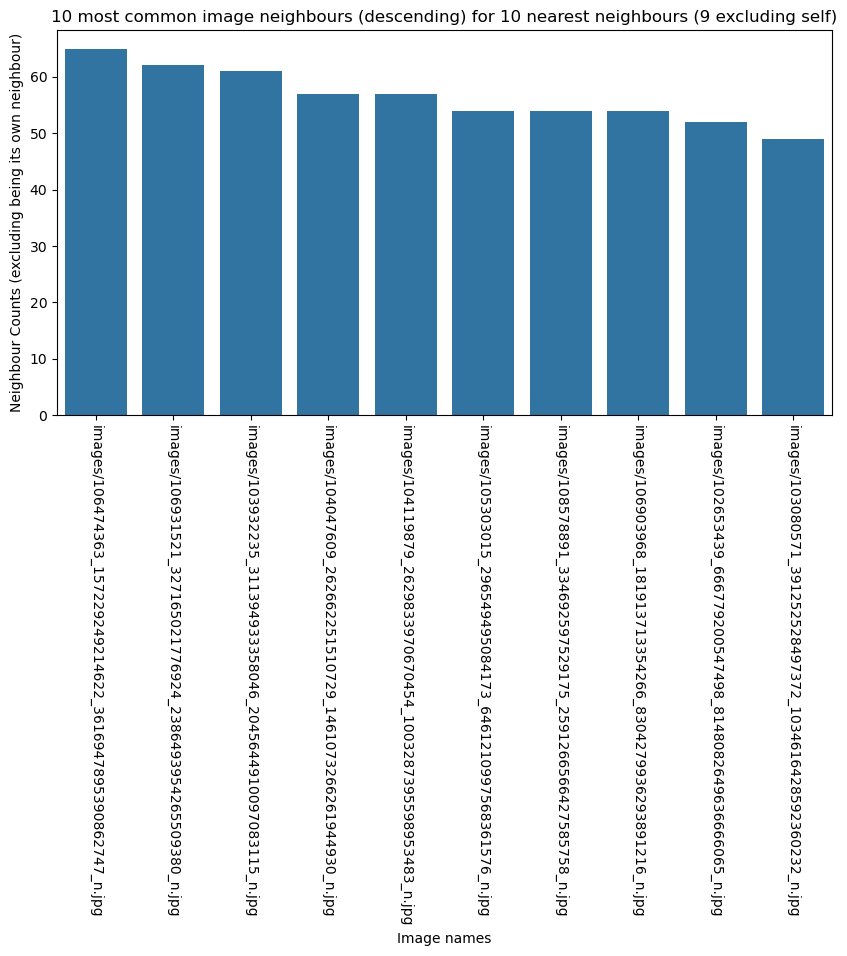

images/106474363_157229249214622_3616947895390862747_n.jpg


In [46]:
count_neighbour_occurances_array = get_count_neighbour_occurances(nearest_neighbours_array)
ranked_neighbour_occurances = rank_neighbour_occurances(count_neighbour_occurances_array, ascending=False)

n_most_common = 10
x=[image_filenames[idx] for idx in ranked_neighbour_occurances[0:n_most_common]]
y=[count_neighbour_occurances_array[idx] -1 for idx in ranked_neighbour_occurances[0:n_most_common]] # the -1 is to exclude counting being its own neighbour
plt.figure(figsize=(10,5))

sns.barplot(x=x, y=y)

plt.xticks(rotation=270)
plt.xlabel("Image names")
plt.ylabel("Neighbour Counts (excluding being its own neighbour)")
plt.title(f"{n_most_common} most common image neighbours (descending) for 10 nearest neighbours (9 excluding self)")

plt.show()
print(x[0])

show the top image neighbour

In [47]:
# display(pillow_images[ranked_neighbour_occurances[0]])

### 4.2 Closest image to its neighbours (average)

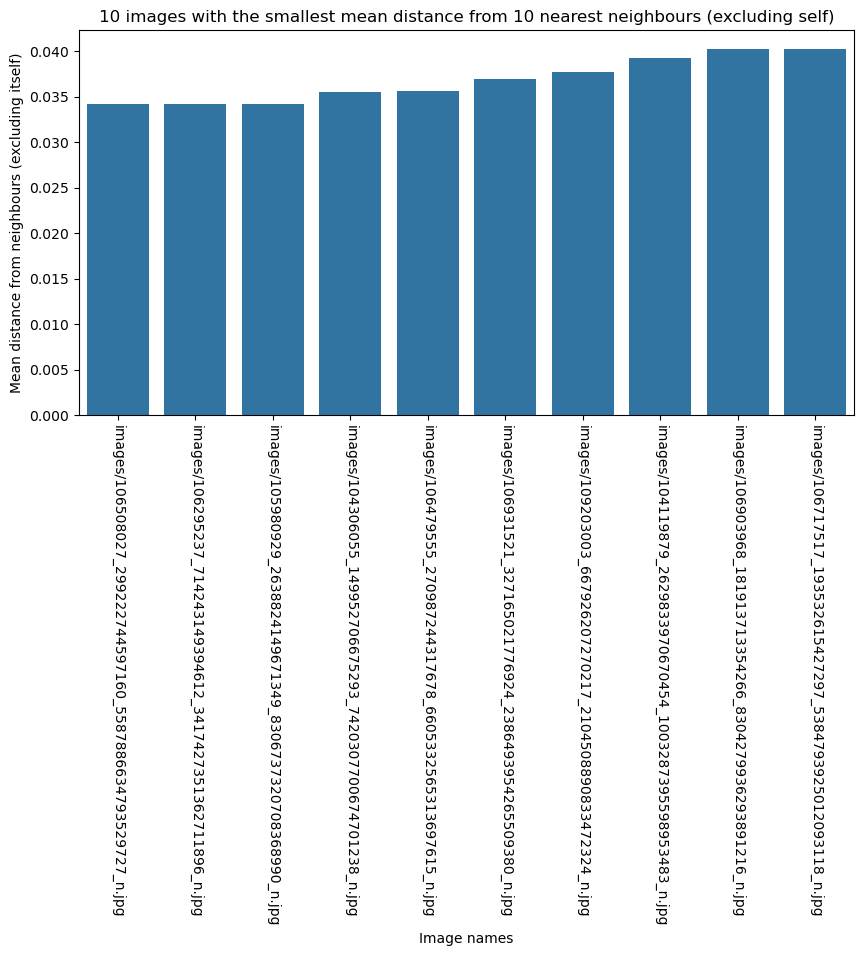

images/106508027_299222744597160_5587886634793529727_n.jpg


In [48]:
neighbours_mean_distance_array = get_mean_distance(neighbours_distance_array)
ranked_neighbour_occurances = rank_neighbour_occurances(neighbours_mean_distance_array, ascending=True)

n_most_common = 10
x=[image_filenames[idx] for idx in ranked_neighbour_occurances[0:n_most_common]]
y=[neighbours_mean_distance_array[idx] for idx in ranked_neighbour_occurances[0:n_most_common]] # the -1 is to exclude counting being its own neighbour
plt.figure(figsize=(10,5))

sns.barplot(x=x, y=y)

plt.xticks(rotation=270)
plt.xlabel("Image names")
plt.ylabel("Mean distance from neighbours (excluding itself)")
plt.title(f"{n_most_common} images with the smallest mean distance from 10 nearest neighbours (excluding self)")

plt.show()
print(x[0])

Show the "closest" neighbour

In [49]:
# display(pillow_images[ranked_neighbour_occurances[0]])

### 4.3 Histogram for times an image appears as a nearest neighbour

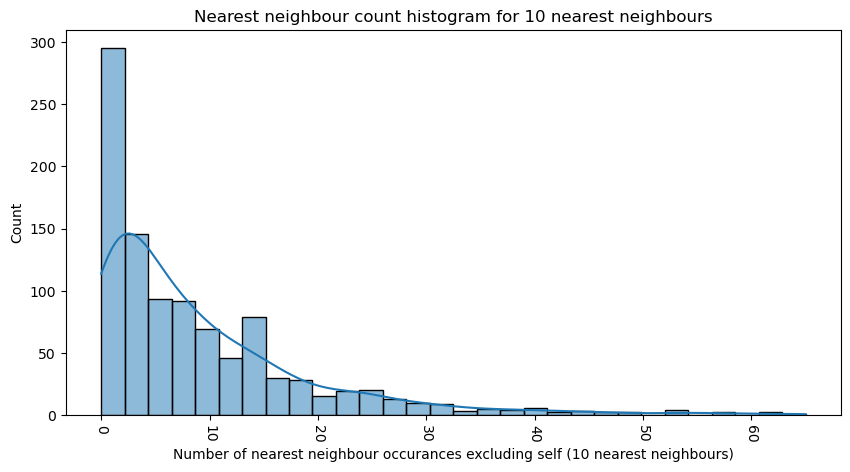

In [50]:
sorted_count_neighbour_occurances_array = np.sort(get_count_neighbour_occurances(nearest_neighbours_array))-1 # -1 to exclude self

plt.figure(figsize=(10,5))

sns.histplot(x=sorted_count_neighbour_occurances_array, kde=True, bins=30)

plt.xticks(rotation=270)
plt.xlabel(f"Number of nearest neighbour occurances excluding self ({number_of_neighbours} nearest neighbours)")
plt.ylabel("Count")
plt.title(f"Nearest neighbour count histogram for {number_of_neighbours} nearest neighbours")

plt.show()


### 4.4 Histogram for an images mean distance across its neighbours

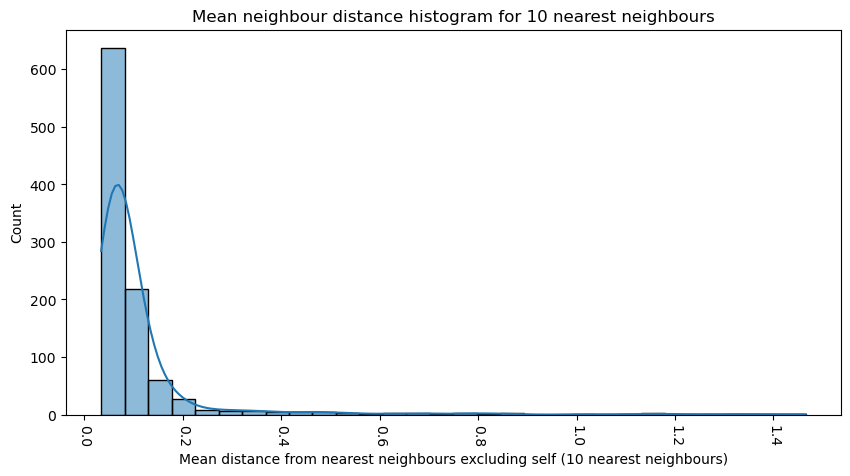

In [51]:
log = False

if log:
    sorted_mean_distance_array = np.log(np.sort(get_mean_distance(neighbours_distance_array)))
    title = "Log mean"
else:
    sorted_mean_distance_array = np.sort(get_mean_distance(neighbours_distance_array))
    title = "Mean"

plt.figure(figsize=(10,5))

sns.histplot(x=sorted_mean_distance_array, kde=True, bins=30)

plt.xticks(rotation=270)
plt.xlabel(f"{title} distance from nearest neighbours excluding self ({number_of_neighbours} nearest neighbours)")
plt.ylabel("Count")
plt.title(f"{title} neighbour distance histogram for {number_of_neighbours} nearest neighbours")

plt.show()


### 4.5 Visualise the embeddings for the most and least common nearest neighbours

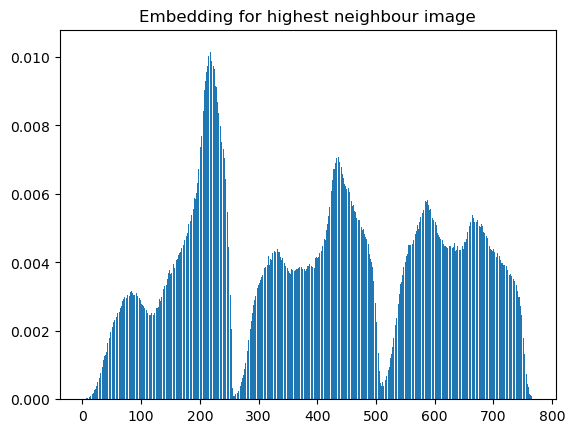

In [52]:
max_index = np.argmax(count_neighbour_occurances_array)

plt.bar(np.arange(len(embedding[max_index])), embedding[max_index])
plt.title("Embedding for highest neighbour image")
plt.show()

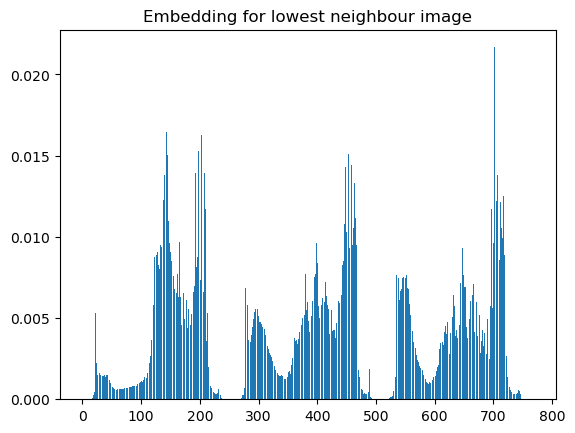

In [53]:
min_index = np.argmin(count_neighbour_occurances_array)

plt.bar(np.arange(len(embedding[min_index])), embedding[min_index])
plt.title("Embedding for lowest neighbour image")
plt.show()

### 4.6 Force directed diagram code
create an interactive "network plot" with a heatmap for aid in visualisation. Use different colours for each cluster.

The code for viewing these plots can be seen in force_directed_diagram.py, the following code in this section is used to create the force directed diagram in the output html files

In [46]:
def get_position_df(nearest_neighbours_array, neighbours_distance_array):
    # Create the graph
    G = nx.Graph()
    for i, neighbors in enumerate(nearest_neighbours_array):
        for neighbor in neighbors:
            if i != neighbor:  # Avoid self-loops
                # add a very small number to prevent divide by 0, is there a better way to handle this?
                weight = 1/((neighbours_distance_array[i][np.where(nearest_neighbours_array[i] == neighbor)[0][0]])+1e-20)
                G.add_edge(i, neighbor, weight=weight)

    # Visualize the graph
    # key value pair of index and position
    pos = nx.spring_layout(G, iterations=100, seed=42, k=None, weight='weight')  # Use spring layout for positioning
    # nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=100)
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))

    return pd.DataFrame(data={"index":list(pos.keys()),"x":np.array(list(pos.values()))[:,0],"y":np.array(list(pos.values()))[:,1]})

# position_df = get_position_df(nearest_neighbours_array, neighbours_distance_array)

def get_diagram_data(nearest_neighbours_array, neighbours_distance_array, cluster_labels, image_filenames, return_json=True):
    position_df = get_position_df(nearest_neighbours_array, neighbours_distance_array)

    # Compute the KDE using scipy
    kde = gaussian_kde([position_df['x'], position_df['y']])
    grid = np.linspace(min(position_df['x'].min(), position_df['y'].min()), 
                    max(position_df['x'].max(), position_df['y'].max()),
                    100) # done this way to make square plot


    X, Y = np.meshgrid(grid, grid)

    # Evaluate the KDE on the grid
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    colours = [colormaps.get_cmap("tab20")(value) for value in np.linspace(0,1,len(set(cluster_labels)))]
    colours = np.hstack((np.array(colours)[:,0:3]*255, np.array(colours)[:,3:4])) 
    rgba_colours = [
        f"rgba({','.join(str(int(num)) for num in colours[label])})"
        for label in cluster_labels
    ]

    diagram_data = {"grid":grid.tolist(), 
            "Z":Z.tolist(), 
            "x":position_df['x'].tolist(), 
            "y":position_df['y'].tolist(), 
            "index":position_df['index'].tolist(), 
            "rgba_colours":rgba_colours,
            "image_filenames": image_filenames.tolist()}
    
    if return_json:
        return json.dumps(diagram_data)
    
    return diagram_data

### 4.7 Pie chart for images in each cluster
this is to represent the cluster size disparity

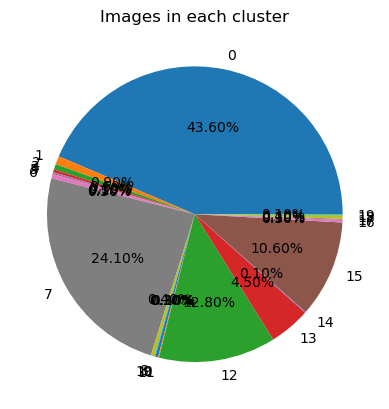

In [55]:
labels, counts = np.unique(cluster_labels, return_counts=True) 

plt.pie(counts, labels=labels, autopct='%.2f%%')
plt.title("Images in each cluster")
plt.show()

# 5. HTML Export 
Create a "summary" HTML document. 

In [45]:
# This function is to allow you to refetch all the needed html rendering requirements for a given embedding
def get_html_rendering_details(embedding_name, pillow_image_filenames, pillow_images,  number_of_neighbours=10, n_clusters=10):
    """The image_filenames passed in is to ensure that the pillow image, image filenames, and embeddings are all compatibile """
    try:
        embedding = np.load(f"./output/image_embedding_{embedding_name}.npy")
        embedding_image_filenames = np.load(f"./output/image_filenames_{embedding_name}.npy")
    except:
        print('Embeddings not saved. ') #! todo make it render?
        return 
    
    if all(embedding_image_filenames != pillow_image_filenames):
        raise "Saved filenames and current filenames don't match" 

    nearest_neighbours_array, neighbours_distance_array = get_knn(embedding, number_of_neighbours)
    cluster_labels = get_cluster_labels(embedding, n_clusters=n_clusters)

    diagram_data = get_diagram_data(nearest_neighbours_array, neighbours_distance_array, cluster_labels, embedding_image_filenames, return_json=True)
    
    return nearest_neighbours_array, neighbours_distance_array, image_filenames, pillow_images, diagram_data, cluster_labels


# regarding colour_map: If you are using above 20 clusters, try "viridis" or a similar continuous map
# This lists the avaliable colormaps for the cluster colouring, recommended tab10 or tab20 for good colour differentiation
# list(colormaps)
def generate_html(nearest_neighbours_array, neighbours_distance_array,image_filenames, pillow_images, diagram_data, cluster_labels, group_clusters=False, image_filepath = "../images/", colour_map="tab20", encode_data=True):
    """Generates string html file to display the images and relevant information.
    group_cluster options:
    - `False`: Sort by rank normally
    - `True`: Order by Cluster label order
    - `asc`: Sort by ascending cluster size order
    - `desc`: Sort by descending cluster size order
    - `rank`: Sort by the highest ranked image in each cluster
    
    It is assumed that cluster_labels is a list of consecutive integers beginning with 0 (So they may be used as indices).
    Do not change encode_data from True, this was a legacy feature."""

    plotly_data = ""
    if encode_data:
        # make it so that instead of image src pointing to an image, it contains the image

        def get_resized_b64(image, set_height=150):
            def resize_image(image, set_height):
                # Calculate the new height keeping the aspect ratio
                width, height = image.size
                new_width = int((set_height / height) * width)
                
                # Resize image
                resized_image = image.resize((new_width, set_height))
                return resized_image
            
            im_file = BytesIO()
            resized_img = resize_image(image, 150)
            resized_img.save(im_file, format="JPEG")
            im_bytes = im_file.getvalue()  # im_bytes: image in binary format.
            im_b64 = base64.b64encode(im_bytes)
            return im_b64.decode("utf-8")
        
        diagram_data_dict = json.loads(diagram_data)
        diagram_data_dict['image_filenames'] = [get_resized_b64(img) for img in pillow_images]
        diagram_data = json.dumps(diagram_data_dict)
        del diagram_data_dict
        image_filepath = "data:image/jpeg;base64,"

        # add plotly
        response = requests.get("https://cdn.jsdelivr.net/npm/plotly.js-dist-min")
        plotly_data = response.text
        del response

    count_neighbour_occurances_array = get_count_neighbour_occurances(nearest_neighbours_array)
    ranked_indices = rank_neighbour_occurances(count_neighbour_occurances_array, ascending=False)
    number_of_neighbours = len(nearest_neighbours_array[0])
    number_of_clusters = len(set(cluster_labels))

    colours = [colormaps.get_cmap(colour_map)(value) for value in np.linspace(0,1,number_of_clusters)]

    neighbours_mean_distance_array = get_mean_distance(neighbours_distance_array)

    max_neighbour_occurances = max(count_neighbour_occurances_array) - 1 # -1 to exclude self
    max_mean_distance = max(neighbours_mean_distance_array)

    row_template = """ 
            <tr id="{}">
                <td><div style="width: 100%; background-color: rgba({},{},{},{}); height: 150px;">{}. ({}) [{}]</div></td>
                <td><div style="width: {}%; background-color: DarkSeaGreen; height: 150px;text-align:right;white-space: nowrap;">{} ({}%)</div></td>
                <td><div style="width: {}%; background-color: CornflowerBlue; height: 150px;text-align:right;white-space: nowrap;">{} ({}%)</div></td>
                <td>{}</td>
                <td>{}</td>
                <td><img id="image_{}" alt="Image" style="width:auto; height:150px;"></td>
            </tr>"""
    
    table_rows = """"""
    # iterate through the ranks
    # rank = 1 means this image has the most neighbours
    def generate_nearest_neighbours_html(nearest_neighbours):
        link_template = '<a href="#{}">{}</a>'
        formatted_nearest_neighbours = [link_template.format(idx, idx) for idx in nearest_neighbours]
        nearest_neighbours_html = ", ".join(formatted_nearest_neighbours)
        return nearest_neighbours_html

    def generate_html_image_module(index, rank):
        """This will generate the html for a given image"""
        # can use index to get filename, nearest_neighbours, and count of nearest neighbours
        
        filename = image_filenames[index]
        nearest_neighbours = nearest_neighbours_array[index]
        count_neighbour_occurances = count_neighbour_occurances_array[index] -1 # -1 to exclude self
        mean_distance = neighbours_mean_distance_array[index]
        mean_distance_percentage = round(mean_distance*100/max_mean_distance,2)
        nearest_neighbours_html = generate_nearest_neighbours_html(nearest_neighbours)
        neighbour_occurance_percentage = round(count_neighbour_occurances*100/max_neighbour_occurances,2)
        cluster_label = cluster_labels[index] # as cluster_label includes 0 can use as an index
        colour = colours[cluster_label] # need to convert to rgba format (* by 255)
                

        return row_template.format(index,
                                   colour[0]*255,colour[1]*255,colour[2]*255,colour[3], rank,index, cluster_label, # assign rgba colours
                                   neighbour_occurance_percentage, count_neighbour_occurances, neighbour_occurance_percentage,
                                   mean_distance_percentage, "{:.2e}".format(mean_distance), mean_distance_percentage, # scientific notation as some embedding types have very small distances
                                   filename, 
                                   nearest_neighbours_html,
                                   index)#image_filepath+filename)

    
    # idx in this case is the item in the list, not the index of the item in the list
    # this is an index referencing the other lists

    if group_clusters: # group_clusters can be "asc" "desc" "rank", any other truthy value will sort by cluster name
        
        # Sort by either Asc or Desc based off the highest ranking RKNN image in the cluster
        if group_clusters == "asc" or group_clusters == "desc":
            _, counts = np.unique(cluster_labels, return_counts=True) 
            # argsort
            ordered_cluster_labels = np.argsort(counts)
            if group_clusters == "desc":
                ordered_cluster_labels = ordered_cluster_labels[::-1]

        elif group_clusters == "rank":
            ordered_cluster_labels = []
            for index in ranked_indices:
                if cluster_labels[index] not in ordered_cluster_labels:
                    ordered_cluster_labels.append(cluster_labels[index])
                    if len(ordered_cluster_labels) == len(set(cluster_labels)):
                        break # if we have all cluster labels break
        
        else: # Any other truthy value
            ordered_cluster_labels = set(cluster_labels)

        # this gets all of cluster 0 in rank order then all of cluster 1 in rank order etc.
        for idx, rank in [(index, rank+1) for target_cluster in  ordered_cluster_labels
                          for rank, index in enumerate(ranked_indices) 
                          if cluster_labels[index] == target_cluster]:
            table_rows += generate_html_image_module(idx, rank)
        cluster_text = " (and grouped by cluster)"
    else:
        for rank, idx in enumerate(ranked_indices):
            table_rows += generate_html_image_module(idx, rank+1) # rank starts at 0

        cluster_text=""
    with open("html_file_template.txt", 'r') as file:
        file_template = str(file.read())
        return file_template.format(
        number_of_clusters=number_of_clusters,  # Replace with actual value
        number_of_neighbours=number_of_neighbours,  # Replace with actual value
        table_rows=table_rows,
        data_json=diagram_data,
        cluster_text=cluster_text,
        image_path=image_filepath,
        plotly_data=plotly_data,
    )

Create single output file using previously made variables

In [57]:
# %%time

# html_file = generate_html(nearest_neighbours_array, neighbours_distance_array, image_filenames, pillow_images, diagram_data, cluster_labels, group_clusters=False, encode_data=True)

# with open("./output/output.html",'w') as file:
#     file.write(html_file)

CPU times: user 8.95 s, sys: 4.13 s, total: 13.1 s
Wall time: 1min 19s


Now add all in one rendering with picking embedding.

PLEASE NOTE: If running this in binderhub and you want to view these files in browser, it seems that you must set `encode_data` to `True`, and right click + `Open in New Browser Tab` the html file.

In [ ]:
%%time


# Please ensure that the embeddings have been created for all embeddings ni the list, 
# and that the embeddings we're created on the same image_filenames, and pillow_images defined at the top of the notebook
embedding_name_list = ['hist','clip', 'vgg19','vgg16']
number_of_neighbours=10
n_clusters=20
group_clusers=False
image_filepath = "../images/"
colour_map="tab20"
encode_data=True

for embedding_name in embedding_name_list:
    html_file = generate_html(*get_html_rendering_details(embedding_name, image_filenames, pillow_images, number_of_neighbours=number_of_neighbours, n_clusters=n_clusters), 
            group_clusters=group_clusers, 
            image_filepath = image_filepath, 
            colour_map=colour_map,
            encode_data=encode_data)

    with open(f"./output/output_{embedding_name}.html",'w') as file:
        file.write(html_file)

    print(f"Completed export for {embedding_name}")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Completed export for hist
Completed export for clip
Completed export for vgg19
Completed export for vgg16
CPU times: user 1min 9s, sys: 10.8 s, total: 1min 20s
Wall time: 2min 50s


## Observations

- You can change the amount of clusters for different advantages 
    - Lower neighbours will create more branches, as it isolates small "groups"
    - Higher neighbours will be more central, but accentuate the very different groups 

- interestingly across the board the clusters don’t seem to be significant predictors of location on the force directed diagram, they appear to largely capture different things. This may be due to a lack of clusters.
- Overall, VGG16 and CLIP tend place pizza, burgers, “documents” (like menus, text ads), and furniture by themselves on their own 'branches'.

histogram:
- the mean distance histogram appears constantly decreasing 
- images with a similar amount of all types of pixels appear to have more neighbours than ones that are colour dominated
- the force directed diagram is centralised with two branches, the lower branch seems to be images that are white dominated, and the upper branch has a cluster of images with black backgrounds and yellow text!
- there is a more minor branch going down that has images with black backgrounds and white text, and navy backgrounds with white text
- the nearest neighbour count histogram is fairly uneven
- Some clusters are very explicit:
    - 9: pastel pink dominated
    - 8: Black and blue dominated
    - 6: very white dominated
    - 5: navy dominated
    - 4: "lime green" dominated 
    - 3: pure black and white
    - 2: primarily black and yellow
    - 1: Images with lots of white but a good mix of other colours

VGG16:
- images with a more uniform probability distribution tend to appear more as a nearest neighbour, meaning things that vgg16 classifies as 'definitely one thing' tend to appear less as neighbours

- much more uneven 10 smallest mean distance
- extremely uneven nearest neighbour count histogram
- fairly normal mean distance histogram with a spike in the smallest bin

- “Spider-like” force directed diagram (lots of legs branching from a central hub)
    - one arm (prominent bottom left) consists of people holding cups
    - arm (bottom right) largely of rectangles with writing (e.g. informative images, menus, etc.)
    - arm (vertical up) largely top down view of dishes with a central brown-dominated food
    - arm (top right) food centred on a proportionately quite large white plate
    - arm (centre right) ice cream/dessert looking foods
    - arm (top left) “hot pot” looking foods in black bowls/cooking pots

- Cluster features:
    - 0: white furniture
    - 1: mostly white rectangles with text (not photos but computer graphics)
    - 5: burgers
    - 7: pizza
    - 8: food in black bowls
    - 9: hot dog-ish foods


CLIP:
- it seems that images with “more things going on” seem to have more neighbours, this may have something to do with the patches that CLIP creates
- Very even 10 smallest mean distance graph
- Unbalanced nearest neighbour count graph
- “Normal” looking mean neighbour distance graph

- looking at the embedding graph, the highest and lowest neighbours appear to have 3 major spikes in the same places, and look quite similar. (this tracks with the even mean distance graph)
- force directed diagram is quite central with 4 large spikes
    - bottom left: pizza
    - bottom central: burgers
    - central right: “sheets with text” computer graphics
    - upper right: white/gray furniture photos

- Cluster features
    - 0: Tables, chairs, and drawers/dressers
    - 1: “flat” images with text (like things made in canva)
    - 3: Desserts/pastries
    - 5: Often things with two dishes (two plates, a plate and a cup) etc.
    - 6: every photo has a person or dog (or something that could be mistaked for the above)
    - 7: Burgers
    - 8: People holding things (or photos with one "thing" in them)
    - 9: Mostly Coffee (and a couple other drinks)

- Note: CLIP Very strongly put photos with a person or dog in one cluster (and had a different cluster for people holding things). It seems like CLIP has been trained on a lot more photos of people than VGG16. Clip is also much “better” at putting things together, VGG16 in the burger cluster had a lot more things that looked like burgers but weren’t burgers.
- the CLIP clusters tended to be much more differentiable to the eye than the VGG16 ones, it. It has clearly been trained on things like burgers, humans, dogs, hands, and coffee

## Notes to self

### make visualisation of the dimension values for top neighbour vs bottom

is the nearest neighbour graph of a specific set of images and embeddings a useful way for navigating/making sense of a dataset



1. histogram for counts of neighbours ✅
2. make a html document with image, number of nearest neighbours, sorted from top to bottom ✅

Embeddings:
- vgg (16) (see if specific package just for vgg) ✅
- check papers sent (single layer feature networks)
- surf feature extractor (implementation in scikit image)
- clip 

constraints:
- needs to run on windows (no tensorflow?)
- pytorch based things? (pytorch cpu backend)
- need to work on cpu + not be slow
- ~~ coffee break to do initial processing (5-15 for 20 000) (everything else can be interactive so can sit and wait)
- embedding step is linear, knn is ^1.1ish

one of the 

use np standard to write the embedded array and KNN array and the filename array ✅

ideas:
- can do a colour coded histogram for count of neighbours with multiple types of embeddings

Experiment with batching first and see how much it helps, see if it takes advantage of multiple threads natively

1. performance comparison between clip and vgg
2. note other experiments and return next week 
3. start exploring different visualisations with KNN graph

    a. select an image and see the nearest neighbours of the image
    
    b. experiment before and loop into heaps and other image display things

1. seriation and clustering (look into displays for clutering, cluster number and different table backgrounds)
2. experiment with networks + more displays like % neighbours bar 
3. keep going through different embeddings, write down different notes/observations with different embeddings (stuff with clip being more even distr than)

Presentation:
- 5 min on introductions (where everyone works and what they are intersted in)
- preamble to set the scene, why this projects
- I give an overview of what I've done so far, general architecture, discuss different experiments, end with html index
    - Talk through the components 

- Ask if this is something that might be useful in general
- Ask what kind of workflow makes sense
    - What kind of images and where
    - Where is the data stored

- Would you be able to test out a notebook in the next few weeks?


- what import format
- what to consider and where
- what output format and where

- select the embedding type in html

Look into ipy widgets for selecting embeddings etc.https://ipywidgets.readthedocs.io/en/stable/
https://github.com/Australian-Text-Analytics-Platform/discursis
- look up binderhub (make sure dependencies preinstalled)
    - requirements.txt at root of repository 
    

1. add network graph into html
2. get selection to work properly
3. way to select embedding
4. set up requirements.txt and prepare for binderhub
5. Set up and test in binderhub

Look into downloading it:   <script src="https://cdn.jsdelivr.net/npm/plotly.js-dist-min"></script>

- figure out how to load images into the html file
    - Save smaller res 
    - Optimise storage with regards to grid view (can you index one list)
    - look into installing cpu only nvidia

- Make it user friendly 


Ideas for html text:

Nearest Neighbour Image visualisation

Welcome! 

Components:
1. force directed diagram 
    - A visualisation based off of embedding distances and K nearest neighbours.
    - Includes a KDE plot to aid in visualising density
    - Points can be hovered over to display their image index
    - Different point colours represent different clusters
    - **Groups of points can be selected to be displayed on the grid, and to filter the image table.**
2. Image grid
    - Displays the last selected images 
    - Can scroll to view all images when many are selected
3. Image table
    - Display ranking in list of reverse nearest neighbours, and index and cluster displayed in a way to be easy to find with COMMAND FIND 
    - Number of reverse nearest neighbours and percentage fill for easy visualisation
    - Mean distance to all nearest neighbours and percentage fill for easy visualisation
    - image filename
    - List of K nearest neighbours with clickable links
    - Thumbnail of image 

Options:
- SEARCH FOR IMAGES OR CLUSTERS WITH COMMAND FIND AND () [] respectively
- Compare this documents look with different embeddings
- Compare this documents look with different amounts of nearest neighbours + clusters
- Group by Cluster
    - Size of cluster (<code>asc</code>/<code>desc</code>)
    - Highest rank in cluster
- Encode data into html document (increases size but allows it to be used standalone)


image upload:
- flat zipped image file
- flat zipped folder with mixture of images and non images
- nested folders of images (zipped + unzipped)
- nested folders where only some should be included
start with first one and progress, **test with 10 image dataset**

work on making the code nicer and structured

put the template in a .txt

consider where to go in terms of keeping large diagrams
- should become clearer with writing

- consider zipping output folder

https://discuss.pytorch.org/t/training-crashes-due-to-insufficient-shared-memory-shm-nn-dataparallel/26396/7